In [1]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row

from pyspark.sql.functions import when, udf, col, regexp_replace
from pyspark.sql.types import DoubleType,IntegerType, StringType

In [2]:
sc = SparkContext( 'local' )
sqlCtx = SQLContext( sc )

In [3]:
df = sqlCtx.read.csv( 'data/births.txt', inferSchema=True)

In [4]:
df = df.withColumnRenamed('_c0','year') \
  .withColumnRenamed('_c1','boys') \
  .withColumnRenamed('_c2','girls')

In [5]:
df.show()

+----+--------+--------+
|year|    boys|   girls|
+----+--------+--------+
|1880| 90993.0|110491.0|
|1881| 91954.0|100745.0|
|1882|107850.0|113688.0|
|1883|112321.0|104629.0|
|1884|129022.0|114445.0|
|1885|133055.0|107800.0|
|1886|144535.0|110784.0|
|1887|145982.0|101414.0|
|1888|178627.0|120853.0|
|1889|178366.0|110584.0|
|1890|190377.0|111025.0|
|1891|185482.0|101196.0|
|1892|212346.0|122037.0|
|1893|212906.0|112317.0|
|1894|222922.0|115772.0|
|1895|233630.0|117398.0|
|1896|237920.0|119570.0|
|1897|234202.0|112758.0|
|1898|258770.0|122693.0|
|1899|233023.0|106212.0|
+----+--------+--------+
only showing top 20 rows



In [6]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- boys: double (nullable = true)
 |-- girls: double (nullable = true)



    1. 2000년도 이후 데이터를 구하시요
    2. 1995~2000 년도 데이터를 구하시요
    3. 남아출생이 가장많은 top5를 구하시요(년도,남아수 출력)
    4. 남아율(%)컬럼을 추가하고 각년도별 남아수가 차지하는 비율을 보여주시요
    5. 2000년도 이후 데이터를 바차트로 보여주시요

In [8]:
# 1. 2000년도 이후 데이터를 구하시요
df_one = df.where("year> 2000")
df_one.toPandas()

,year,boys,girls
0,2001,1799049.0,1941251.0
1,2002,1795206.0,1939815.0
2,2003,1825359.0,1973434.0
3,2004,1834145.0,1982794.0
4,2005,1845379.0,1994841.0
5,2006,1898463.0,2052377.0
6,2007,1919408.0,2072139.0
7,2008,1887234.0,2036289.0
8,2009,1832925.0,1979303.0
9,2010,1772738.0,1913851.0


In [9]:
# 2. 1995~2000 년도 데이터를 구하시요
df_two = df.where('(year>=1995) and (year<=2000)')
df_two.toPandas()

,year,boys,girls
0,1995,1757927.0,1902832.0
1,1996,1752249.0,1893378.0
2,1997,1739806.0,1884122.0
3,1998,1765915.0,1910250.0
4,1999,1772632.0,1918809.0
5,2000,1814601.0,1962406.0


In [10]:
df.where( "year between 1995 and 2000").show()

+----+---------+---------+
|year|     boys|    girls|
+----+---------+---------+
|1995|1757927.0|1902832.0|
|1996|1752249.0|1893378.0|
|1997|1739806.0|1884122.0|
|1998|1765915.0|1910250.0|
|1999|1772632.0|1918809.0|
|2000|1814601.0|1962406.0|
+----+---------+---------+



In [11]:
# 3.  남아출생이 가장많은 top5를 구하시요(년도,남아수 출력)
from operator import attrgetter
df_three = df.rdd.top(5, attrgetter("boys"))
df_three

[Row(year=1957, boys=2044160.0, girls=2155866.0),
 Row(year=1959, boys=2023044.0, girls=2133509.0),
 Row(year=1960, boys=2022093.0, girls=2132717.0),
 Row(year=1961, boys=2017316.0, girls=2122502.0),
 Row(year=1958, boys=2010884.0, girls=2120712.0)]

In [12]:
# df.select('year', 'boys').sort(desc('boys')).show(5)

NameError: name 'desc' is not defined

In [13]:
df.orderBy(df.boys.desc()).limit(5).show()

+----+---------+---------+
|year|     boys|    girls|
+----+---------+---------+
|1957|2044160.0|2155866.0|
|1959|2023044.0|2133509.0|
|1960|2022093.0|2132717.0|
|1961|2017316.0|2122502.0|
|1958|2010884.0|2120712.0|
+----+---------+---------+



In [14]:
df.select('year','boys').orderBy('boys',ascending=False).limit(5).show()

+----+---------+
|year|     boys|
+----+---------+
|1957|2044160.0|
|1959|2023044.0|
|1960|2022093.0|
|1961|2017316.0|
|1958|2010884.0|
+----+---------+



In [15]:
# 4. 남아율(%)컬럼을 추가하고 각년도별 남아수가 차지하는 비율을 보여주시요
df_four = df.withColumn('남아율(%)', df['boys'] / (df['boys']+df['girls']) )
df_four.toPandas()

,year,boys,girls,남아율(%)
0,1880,90993.0,110491.0,0.451614
1,1881,91954.0,100745.0,0.477190
2,1882,107850.0,113688.0,0.486824
3,1883,112321.0,104629.0,0.517728
4,1884,129022.0,114445.0,0.529936
...,...,...,...,...
127,2007,1919408.0,2072139.0,0.480868
128,2008,1887234.0,2036289.0,0.481005
129,2009,1832925.0,1979303.0,0.480802
130,2010,1772738.0,1913851.0,0.480861


In [16]:
df.withColumn('test', df['boys']*2 ).show()

+----+--------+--------+--------+
|year|    boys|   girls|    test|
+----+--------+--------+--------+
|1880| 90993.0|110491.0|181986.0|
|1881| 91954.0|100745.0|183908.0|
|1882|107850.0|113688.0|215700.0|
|1883|112321.0|104629.0|224642.0|
|1884|129022.0|114445.0|258044.0|
|1885|133055.0|107800.0|266110.0|
|1886|144535.0|110784.0|289070.0|
|1887|145982.0|101414.0|291964.0|
|1888|178627.0|120853.0|357254.0|
|1889|178366.0|110584.0|356732.0|
|1890|190377.0|111025.0|380754.0|
|1891|185482.0|101196.0|370964.0|
|1892|212346.0|122037.0|424692.0|
|1893|212906.0|112317.0|425812.0|
|1894|222922.0|115772.0|445844.0|
|1895|233630.0|117398.0|467260.0|
|1896|237920.0|119570.0|475840.0|
|1897|234202.0|112758.0|468404.0|
|1898|258770.0|122693.0|517540.0|
|1899|233023.0|106212.0|466046.0|
+----+--------+--------+--------+
only showing top 20 rows



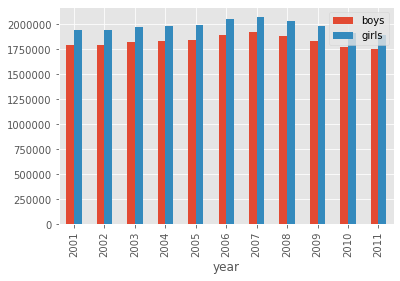

In [17]:
# 5. 2000년도 이후 데이터를 바차트로 보여주시요
import matplotlib.pyplot as plt
plt.style.use('ggplot')

df_five = df_one.toPandas()
df_five.set_index('year' , inplace=True)
df_five.plot(kind='bar')
plt.ticklabel_format(axis='y',style='plain')
plt.show()

In [18]:
sc.stop()